# Networks of organisations


  
* *Exploratory SNA* book's chapter 5 about 'Affiliations'
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/pajek_book/chapter5_affiliations.ipynb) 



In [8]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [9]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [10]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [11]:
print(reload(naf))  

<module 'network_analysis_functions' from 'c:\\Users\\raiku\\Documents\\Humanité numérique\\archivist\\sparqlnotebook\\network_analysis_functions.py'>


## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisations as original information.

Here, however, we will focus on relationships between institutions, so the treatment is different.


In [12]:
## define SPARQL enpoint
endpoint = "https://ag1mdzaeq7qnj00h.allegrograph.cloud/repositories/archivist"

In [13]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/mroylem/archivist/blob/main/Wikidata/graph/imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                # instance of
                wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [14]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


6515
[['http://www.wikidata.org/entity/Q104401',
  'Walter Hirche',
  '1941',
  'membership',
  'http://www.wikidata.org/entity/Q1147735',
  'Verein Deutsche Sprache',
  '2',
  'voluntary association | medical check-up'],
 ['http://www.wikidata.org/entity/Q104467233',
  'Normand Charbonneau',
  '1956',
  'employment',
  'http://www.wikidata.org/entity/Q39628',
  'Bibliothèque et Archives nationales du Québec',
  '4',
  'national library | government agency | public library | national archives'],
 ['http://www.wikidata.org/entity/Q104467233',
  'Normand Charbonneau',
  '1956',
  'employment',
  'http://www.wikidata.org/entity/Q913250',
  'Library and Archives Canada',
  '4',
  'national archives | open-access repository | national library | library']]


## Inspect the data


In [15]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  6515


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg
10,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,education,http://www.wikidata.org/entity/Q1878600,Lycée Henri-IV,2,educational institution | educational facility
11,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,education,http://www.wikidata.org/entity/Q273570,École des chartes,2,grand établissement | grande école
12,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,employment,http://www.wikidata.org/entity/Q280413,National Center for Scientific Research,4,research institute | open-access publisher | o...


### Distribution of relationships in relation to birthYears of organisations members

In [16]:
l_50 = list(range(1761, 2051, 30))
print(l_50)

[1761, 1791, 1821, 1851, 1881, 1911, 1941, 1971, 2001, 2031]


In [17]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [18]:
### 30 years periods, but some customisations
lc = [1751, 1811, 1851, 1881, 1911, 1941, 1971, 2001]

In [19]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [20]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
1,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,employment,http://www.wikidata.org/entity/Q11509930,University Lille-II,1,university in France,1941-1970
5,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,employment,http://www.wikidata.org/entity/Q273631,École pratique des hautes études,2,grand établissement | educational institution,1941-1970
10,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,education,http://www.wikidata.org/entity/Q1878600,Lycée Henri-IV,2,educational institution | educational facility,1941-1970


#### Reload from CSV

This is only possible if you already stored the data into a CSV, cf. below

In [21]:
### load from CSV

file_add = 'data/persons_organisations_from_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

6515


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q100293724,Wieland Mittmannsgruber,1946,education,http://www.wikidata.org/entity/Q682739,Johannes Kepler University Linz,1,campus university,1941-1970,['campus university']
1,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,employment,http://www.wikidata.org/entity/Q11509930,University Lille-II,1,university in france,1941-1970,['university in france']


In [22]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1851-1880    1109
1881-1910    1666
1911-1940    1597
1941-1970    1650
1971-2000     493
dtype: int64


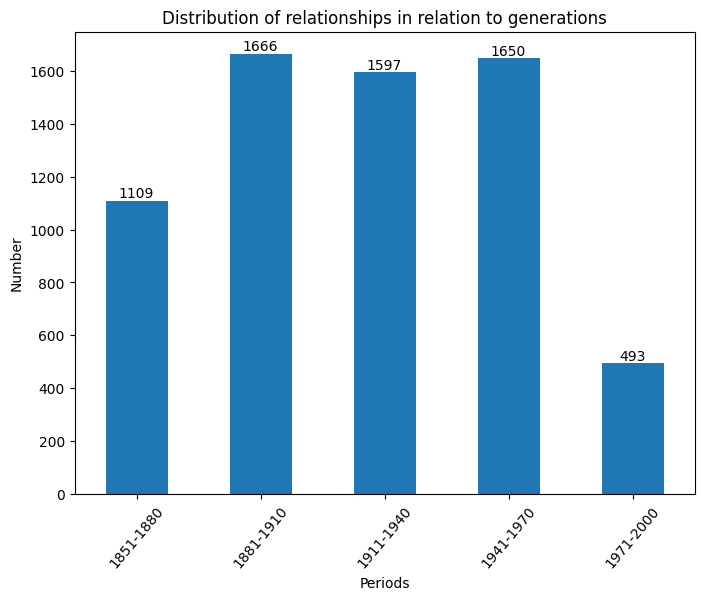

In [23]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Inspect available relationships

In [24]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     2737
employment    2077
membership    1701
dtype: int64


In [25]:
dfg_pr=df_p.groupby(by=['periods','relaType'], observed=True, as_index=False).size()
print(dfg_pr)

      periods    relaType  size
0   1851-1880   education   384
1   1851-1880  employment   250
2   1851-1880  membership   475
3   1881-1910   education   678
4   1881-1910  employment   460
5   1881-1910  membership   528
6   1911-1940   education   701
7   1911-1940  employment   497
8   1911-1940  membership   399
9   1941-1970   education   738
10  1941-1970  employment   673
11  1941-1970  membership   239
12  1971-2000   education   236
13  1971-2000  employment   197
14  1971-2000  membership    60


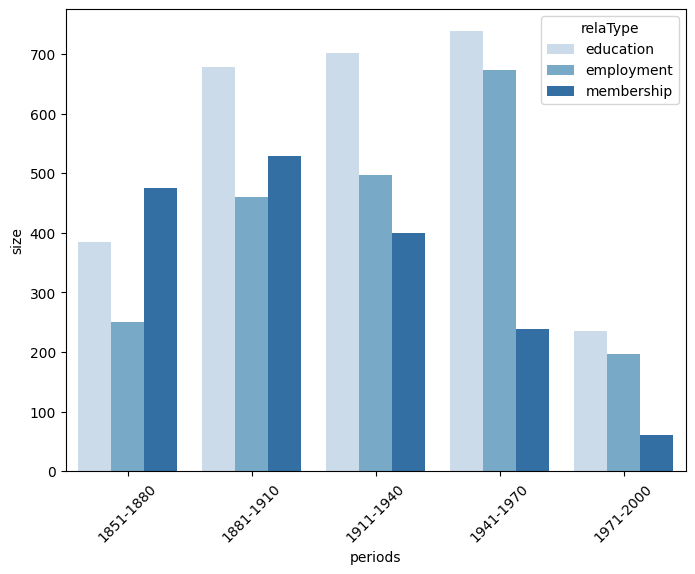

In [26]:
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='relaType', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up organisations type

In [27]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


6515
[['campus university'], ['university in france'], ['lycée']]


In [28]:
## Rebuild the sorted original texts after sorting
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
1,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,employment,http://www.wikidata.org/entity/Q11509930,University Lille-II,1,university in france,1941-1970,[university in france]
5,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,employment,http://www.wikidata.org/entity/Q273631,École pratique des hautes études,2,educational institution | grand établissement,1941-1970,"[educational institution, grand établissement]"
10,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,education,http://www.wikidata.org/entity/Q1878600,Lycée Henri-IV,2,educational facility | educational institution,1941-1970,"[educational facility, educational institution]"


#### Organisations' types distribution

In [169]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

typesOrg
grand établissement | grande école                      370
university                                              222
corporation | organization                              221
learned society                                         200
open-access publisher | university                      149
open-access publisher | public research university      126
faculty | open-access publisher | publishing company    126
organization                                            123
public university                                       109
archive                                                 106
dtype: int64


#### Save dataframe to CSV

In [170]:
file_add = 'data/persons_organisations_from_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

## Types of organisations

Property **wdt:P31 instance of**


We are trying to figure out if we can use these types to distinguish and categorise organisations. We will introduce high-level, research-driven classes that primarily serve a heuristic function and express no objective point of view.

In [184]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,grand établissement | grande école,370,2
1,university,222,1
2,corporation | organization,221,2
3,learned society,200,1
4,open-access publisher | university,149,2
5,open-access publisher | public research univer...,126,2
6,faculty | open-access publisher | publishing c...,126,3
7,organization,123,1
8,public university,109,1
9,archive,106,1


In [185]:
### Print to CSV in order to inspect the data
csv_file='files/network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Add organisation main type

In [186]:
### Inspect the data
df_p.head(1)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
0,http://www.wikidata.org/entity/Q100293724,Wieland Mittmannsgruber,1946,education,http://www.wikidata.org/entity/Q682739,Johannes Kepler University Linz,1,campus university,1941-1970,[campus university],university


In [221]:
def code_organisation_main_type(x):
    val = ''
    if 'institute of technol' in x:
        val = 'institute of technology'
    elif 'corporation' in x:
        val = 'company or gov. agency'
    elif 'organization' in x:
        val = 'company or gov. agency'
    elif 'national archive' in x:
        val = 'national archive'
    elif 'municipal archive' in x:
        val = 'municipal archive'
    elif 'state archive' in x:
        val = 'state archive'
    elif 'archive' in x:
        val = 'other archive'
    elif 'polyt' in x:
        val = 'institute of technology'   
    elif 'public university' in x:
        val = 'public university'
    elif 'école normale sup' in x:
        val = 'public university'    
    elif 'grande école' in x:
        val = 'public university'
    elif 'grand établissement' in x:
        val = 'public university'
    elif 'private university' in x:
        val = 'private university'
    elif 'university' in x:
        val = 'university'   
    elif 'educational inst' in x:
        val = 'educational institution'    
    elif 'military academy' in x:
        val = 'educational institution' 
    elif 'naval academy' in x:
        val = 'educational institution'        
    elif 'art academy' in x:
        val = 'educational institution' 
    elif 'faculty' in x:
        val = 'university'  # could also be 'faculty'
    elif 'academic dep' in x:
        val =  'university'  # could also be 'faculty'    
    elif 'college' in x:
        val = 'educational institution'   # could also be 'college'             
    elif 'gymnas' in x:
        val = 'educational institution'   # could also be 'college'     
    elif 'ies' in x:
        val = 'educational institution'   # could also be 'college'
    elif 'learned society' in x:
        val = 'learned society'     
    elif 'academy of sciences' in x:
        val = 'academy of sciences'
    elif 'research institute' in x:
        val = 'research organisation'
    elif 'max planck' in x:
        val = 'research organisation'
    elif 'institute' in x:
        val = 'research organisation' 
    elif 'research' in x:
        val = 'research organisation'
    elif 'laboratory' in x:
        val = 'research facility'  
    elif 'facility' in x:
        val = 'research facility'   
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'museum' in x:
        val = 'scientific organisation'
    elif 'nonprofit organization' in x:
        val = 'scientific organisation'    
    elif 'national academy' in x:
        val = 'scientific organisation'
    elif 'scientific organization' in x:
        val = 'scientific organisation'
    elif 'higher education' in x:
        val = 'educational institution'
    elif 'school' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academic institution' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academy' in x:
        val = 'learned society'
    elif 'society' in x:
        val = 'learned society'
    elif 'voluntary association':
        val = 'association'
    elif 'professional association':
        val = 'association'
    elif 'association':
        val = 'association'
    elif 'alumni association':
        val = 'association'
    elif 'studentenverbindung':
        val = 'association'
    elif 'burschenschaft':
        val='association'
    elif 'ies':
        val='association'
    elif 'german student corps':
        val='association'
    elif 'cultural institution':
        val='cultural institution'
    elif 'medical check-up':
        val= 'medical'
    elif 'newspaper':
        val='newspaper'
    elif 'library':
        val='library'
    elif 'company' in x \
                or 'business'  in x \
                or 'entrepr' in x:
        val = 'company or gov. agency' # could also be 'company'
    elif 'government' in x :
        val = 'company or gov. agency' # could also be 'government agency'         
    elif 'publish' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'     
    elif 'journal' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'
    elif 'periodical' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'    
    else:
        val = 'not classified organisation'

    return val        

In [222]:
df_p['orgMainType'] = df_p['typesOrg'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
7,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,education,http://www.wikidata.org/entity/Q546118,Paris-Sorbonne University - Paris IV,2,former educational institution | university in...,1941-1970,"[former educational institution, university in...",university
8,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,employment,http://www.wikidata.org/entity/Q999763,University of Paris 1 Pantheon-Sorbonne,1,university in france,1941-1970,[university in france],university
9,http://www.wikidata.org/entity/Q1004154,Frédéric Barbier,1952,employment,http://www.wikidata.org/entity/Q2791269,École nationale supérieure des sciences de l'i...,1,grand établissement,1941-1970,[grand établissement],public university


In [223]:
df_mainTypes = pd.DataFrame(df_p.groupby(by='orgMainType', as_index=False).size().sort_values(by='size',ascending=False))
df_mainTypes.columns=['mainType', 'number']
df_mainTypes

,mainType,number
15,university,1448
10,public university,1252
2,company or gov. agency,1015
1,association,634
3,educational institution,557
5,learned society,533
8,other archive,353
0,academy of sciences,152
7,national archive,131
13,scientific organisation,127


In [224]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby(['typesOrg', 'orgMainType'], as_index=False).\
                        size().sort_values(by='size',ascending=False))
df_types.columns=['typesOrg', 'orgMainType', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
### Print to CSV in order to inspect the data
csv_file='files/network_organisations_with_main_types_groups.csv'
df_types.to_csv(csv_file)

df_types.iloc[7:10]

,typesOrg,orgMainType,number,numberOrg
985,organization,company or gov. agency,123,1
1079,public university,public university,109,1
125,archive,other archive,106,1


#### 'Manual' corrections and classification improvements

In some cases, instpecting the organisations shows that the provided classification is not suitable and should be replaced:

Academia Europaea, ...

We provide this example merely to illustrate the point; further work would be required, but this is beyond the scope of this exercise.

In [225]:
### Please note the warning and the orders fo the filter, after (!) the column 
"""
Do not use:
df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
"""

df_p.loc[df_p.uriOrg == 'http://www.wikidata.org/entity/Q337234', 'orgMainType'] = 'research organisation'
df_p[df_p.labelOrg.str.contains('Europaea')].head(2)



,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
2543,http://www.wikidata.org/entity/Q2035449,Walter Prevenier,1934,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1911-1940,"[academy, charitable organization, organization]",research organisation
2749,http://www.wikidata.org/entity/Q2165608,Ronald G. Asch,1953,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1941-1970,"[academy, charitable organization, organization]",research organisation


# Create graphs

In [226]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     2737
employment    2077
membership    1701
dtype: int64


### Prepare the dataframe

In [227]:
### Select the columns that will be used
df_prep = df_p[['uriPer','labelPer','birthYear','uriOrg', 'labelOrg', 'typesOrg', 'orgMainType', 'relaType', 'periods']].copy(deep=True)
print(len(df_prep))

6515


### Features of organisations

#### General grouping


We first group by organisations, counting all relationships of persons which provides the total degree or number of members over the whole time 

In [228]:
### Memberships by organisations
df_org = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'typesOrg','orgMainType'],as_index=False).size())
df_org.columns=['uriOrg', 'labelOrg', 'typesOrg', 'orgMainType','tot_members_number']
df_org.sort_values('tot_members_number',ascending=False).iloc[:10]

,uriOrg,labelOrg,typesOrg,orgMainType,tot_members_number
1094,http://www.wikidata.org/entity/Q273570,École des chartes,grand établissement | grande école,public university,370
1470,http://www.wikidata.org/entity/Q35854422,"Cuerpo Facultativo de Archiveros, Bibliotecari...",corporation | organization,company or gov. agency,221
1466,http://www.wikidata.org/entity/Q3563550,"Faculty of Arts, Charles University in Prague",faculty | open-access publisher | publishing c...,university,126
1513,http://www.wikidata.org/entity/Q390287,Eötvös Loránd University,open-access publisher | public research univer...,university,122
629,http://www.wikidata.org/entity/Q165980,University of Vienna,university,university,102
1997,http://www.wikidata.org/entity/Q636031,Archivschule Marburg,landesbetrieb | public university | university...,public university,62
1434,http://www.wikidata.org/entity/Q3487972,Société de l’histoire de France,learned society,learned society,49
1221,http://www.wikidata.org/entity/Q28845821,Société de l'histoire de Paris et de l'Île-de-...,learned society | national academy,learned society,46
240,http://www.wikidata.org/entity/Q12016640,Masaryk University Faculty of Arts,philosophy faculty,university,45
1091,http://www.wikidata.org/entity/Q273542,French School of Rome,educational institution | publishing company |...,educational institution,44


In [229]:
### Save list of organisations as CSV
csv_file='files/network_organisations_with_main_type_and_number.csv'
df_org.sort_values('tot_members_number',ascending=False).to_csv(csv_file)

#### Group by period

We then group by heuristic period (or generation)

In [230]:
df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriod.reset_index(inplace=True)
df_orgPeriod.sort_values(by='periods', ascending=True).head()

,uriOrg,labelOrg,orgMainType,periods,period_members_number
0,http://www.wikidata.org/entity/Q1006127,"Bundesgymnasium, Bundesrealgymnasium und Bunde...",educational institution,1851-1880,1
793,http://www.wikidata.org/entity/Q159895,University of Rostock,public university,1851-1880,1
2528,http://www.wikidata.org/entity/Q5274245,Didsbury Campus,educational institution,1851-1880,1
2523,http://www.wikidata.org/entity/Q52440672,École nationale des langues orientales vivantes,educational institution,1851-1880,1
2514,http://www.wikidata.org/entity/Q51955078,The Huguenot Society of Great Britain and Ireland,learned society,1851-1880,1


In [231]:
df_orgPeriod[df_orgPeriod.labelOrg=='University of Rostock']

,uriOrg,labelOrg,orgMainType,periods,period_members_number
793,http://www.wikidata.org/entity/Q159895,University of Rostock,public university,1851-1880,1
794,http://www.wikidata.org/entity/Q159895,University of Rostock,public university,1911-1940,1
795,http://www.wikidata.org/entity/Q159895,University of Rostock,public university,1941-1970,1


#### Group by period and relationship type

We then group by heuristic period (or generation) AND relationship type, i.e. which kind of relationship associates a person to an organisation in the bipartite network

In [232]:
df_orgPeriodRelType = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriodRelType.reset_index(inplace=True)
df_orgPeriodRelType.sort_values(by='period_members_number', ascending=False).head()

,uriOrg,labelOrg,orgMainType,relaType,periods,period_members_number
2306,http://www.wikidata.org/entity/Q35854422,"Cuerpo Facultativo de Archiveros, Bibliotecari...",company or gov. agency,membership,1881-1910,116
1695,http://www.wikidata.org/entity/Q273570,École des chartes,public university,education,1911-1940,84
1694,http://www.wikidata.org/entity/Q273570,École des chartes,public university,education,1881-1910,82
1693,http://www.wikidata.org/entity/Q273570,École des chartes,public university,education,1851-1880,79
1696,http://www.wikidata.org/entity/Q273570,École des chartes,public university,education,1941-1970,77


In [233]:
### Number of relationships by period with type
dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values(['relaType', 'periods'])
file_addr='files/organisations_types_periods_distribution.csv'
dfgt.sort_values(['relaType', 'periods']).to_csv(file_addr)
print(len(dfgt))
dfgt.iloc[:10]

164


,periods,relaType,orgMainType,period_members_number
0,1851-1880,education,association,4
1,1851-1880,education,company or gov. agency,21
2,1851-1880,education,educational institution,62
3,1851-1880,education,learned society,5
4,1851-1880,education,national archive,1
5,1851-1880,education,other archive,1
6,1851-1880,education,private university,10
7,1851-1880,education,public university,148
8,1851-1880,education,research facility,6
9,1851-1880,education,university,126


In [234]:
### Number of relationships without period
dfgw = df_orgPeriodRelType.groupby(['relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values([ 'relaType', 'orgMainType'])
print(len(dfgw))

42


## Bivariate analysis: relationship, organisation type

### Create the needed functions

In [235]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [236]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships, types of organisations

In [237]:


### Contingency table
X = 'relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



relaType,education,employment,membership,Total
orgMainType,,,,
academy of sciences,0,9,143,152
association,38,287,309,634
company or gov. agency,272,209,532,1013
educational institution,358,109,90,557
institute of technology,4,11,0,15
learned society,7,5,521,533
municipal archive,0,56,0,56
national archive,2,128,1,131
other archive,11,290,52,353


In [238]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

relaType,education,employment,membership
orgMainType,,,
academy of sciences,0,9,143
association,38,287,309
company or gov. agency,272,209,532
educational institution,358,109,90
institute of technology,4,11,0
learned society,7,5,521
municipal archive,0,56,0
national archive,2,128,1
other archive,11,290,52


In [239]:
### We observe a strong relationship between these two variables

bivariee_stats(ct_wm)

Chi2 : 5094.53 , dof : 30
p-value : 0.0
phi2 = inertie (variance totale) : 0.781969352220961
Cramer:  0.6252876746830058


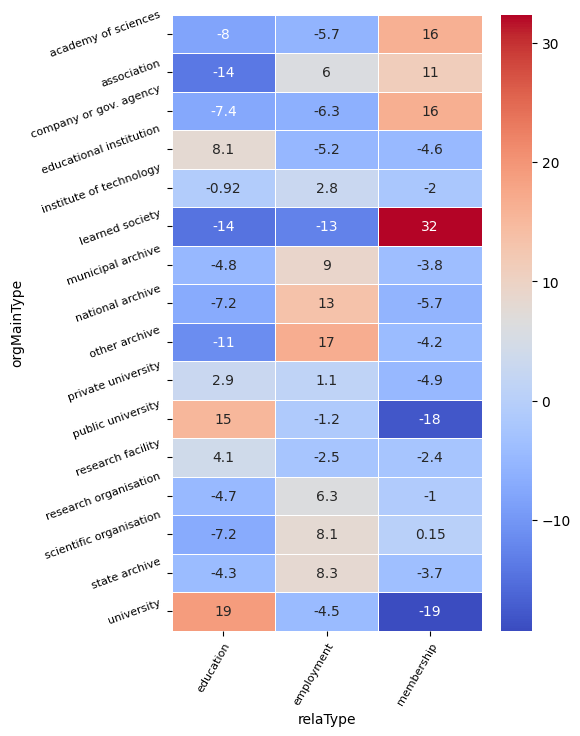

In [240]:
pp = plot_chi2_residuals(ct_wm, figsize=(5, 8))

#### Comment

We observe that some values should be corrected, like memberships in technical organisations that should be employments.

See the following example

In [241]:
pprint.pprint(list(df_p.loc[df_p.orgMainType.str.contains('techno') & df_p.relaType.str.contains('memb') ].items())[:6])

[('uriPer', Series([], Name: uriPer, dtype: object)),
 ('labelPer', Series([], Name: labelPer, dtype: object)),
 ('birthYear', Series([], Name: birthYear, dtype: int64)),
 ('relaType', Series([], Name: relaType, dtype: object)),
 ('uriOrg', Series([], Name: uriOrg, dtype: object)),
 ('labelOrg', Series([], Name: labelOrg, dtype: object))]


### Explore contingency table of relationships to organisations : periods, types of organisations

In [242]:
### Contingency table
X = 'periods'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
orgMainType,,,,,,
academy of sciences,66,41,37,8,0,152
association,106,172,133,164,59,634
company or gov. agency,166,292,253,225,77,1013
educational institution,118,167,138,101,33,557
institute of technology,0,3,2,9,1,15
learned society,167,149,124,76,17,533
municipal archive,5,8,10,28,5,56
national archive,20,21,34,49,7,131
other archive,39,67,96,118,33,353


In [243]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [244]:
### We observe some not so strong relationship between these two variables
bivariee_stats(ct_wm)

Chi2 : 407.28 , dof : 60
p-value : 4.336233599751841e-53
phi2 = inertie (variance totale) : 0.06251416653488734
Cramer:  0.12501416573221547


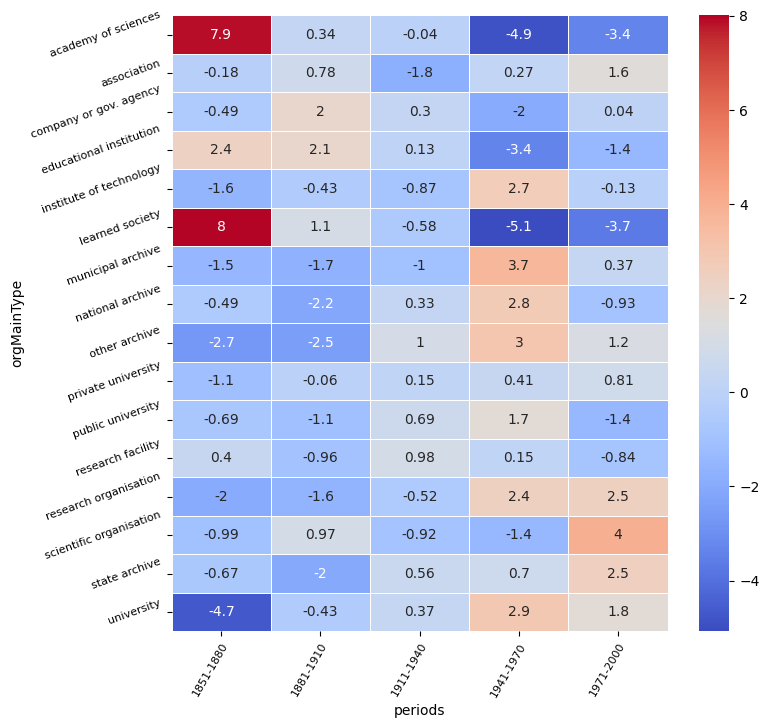

In [245]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 8))

### Explore contingency table of relationships to organisations : periods, types of relationships

In [246]:
### Contingency table
X = 'periods'
Y = 'relaType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
relaType,,,,,,
education,384,678,701,738,236,2737
employment,250,460,497,673,197,2077
membership,475,528,399,239,60,1701
Total,1109,1666,1597,1650,493,6515


In [247]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [248]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 376.19 , dof : 8
p-value : 2.313221957592679e-76
phi2 = inertie (variance totale) : 0.05774147818465094
Cramer:  0.16991391671174397


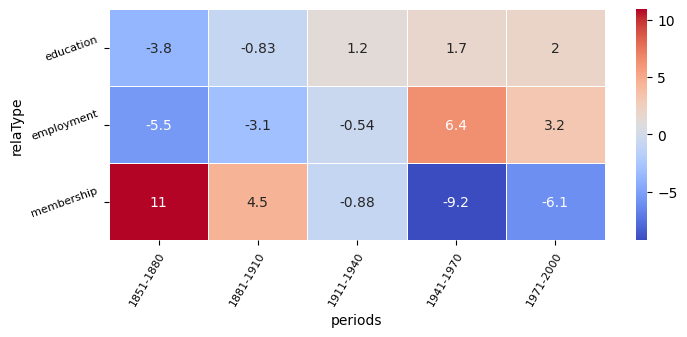

In [249]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 3))

### Explore contingency table of relationships to organisations : periods+types of relationships vs organisations types

In [250]:
df_prep['periods_relaType'] = df_prep.apply(lambda x : x.periods+'_'+x.relaType, axis=1)
df_prep.head(1)

,uriPer,labelPer,birthYear,uriOrg,labelOrg,typesOrg,orgMainType,relaType,periods,periods_relaType
0,http://www.wikidata.org/entity/Q100293724,Wieland Mittmannsgruber,1946,http://www.wikidata.org/entity/Q682739,Johannes Kepler University Linz,campus university,university,education,1941-1970,1941-1970_education


In [251]:
### Contingency table
X = 'periods_relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods_relaType,1851-1880_education,1851-1880_employment,1851-1880_membership,1881-1910_education,1881-1910_employment,1881-1910_membership,1911-1940_education,1911-1940_employment,1911-1940_membership,1941-1970_education,1941-1970_employment,1941-1970_membership,1971-2000_education,1971-2000_employment,1971-2000_membership,Total
orgMainType,,,,,,,,,,,,,,,,
academy of sciences,0,2,64,0,2,39,0,2,35,0,3,5,0,0,0,152
association,4,37,65,8,89,75,12,56,65,11,70,83,3,35,21,634
company or gov. agency,21,18,127,40,49,203,73,51,129,102,70,53,36,21,20,1013
educational institution,62,25,31,108,26,33,90,25,23,71,27,3,27,6,0,557
institute of technology,0,0,0,0,3,0,0,2,0,4,5,0,0,1,0,15
learned society,5,1,161,0,0,149,1,4,119,1,0,75,0,0,17,533
municipal archive,0,5,0,0,8,0,0,10,0,0,28,0,0,5,0,56
national archive,1,19,0,0,20,1,1,33,0,0,49,0,0,7,0,131
other archive,1,25,13,1,53,13,1,81,14,3,103,12,5,28,0,353


In [252]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [253]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 5715.41 , dof : 210
p-value : 0.0
phi2 = inertie (variance totale) : 0.877268977061455
Cramer:  0.2503239297192818


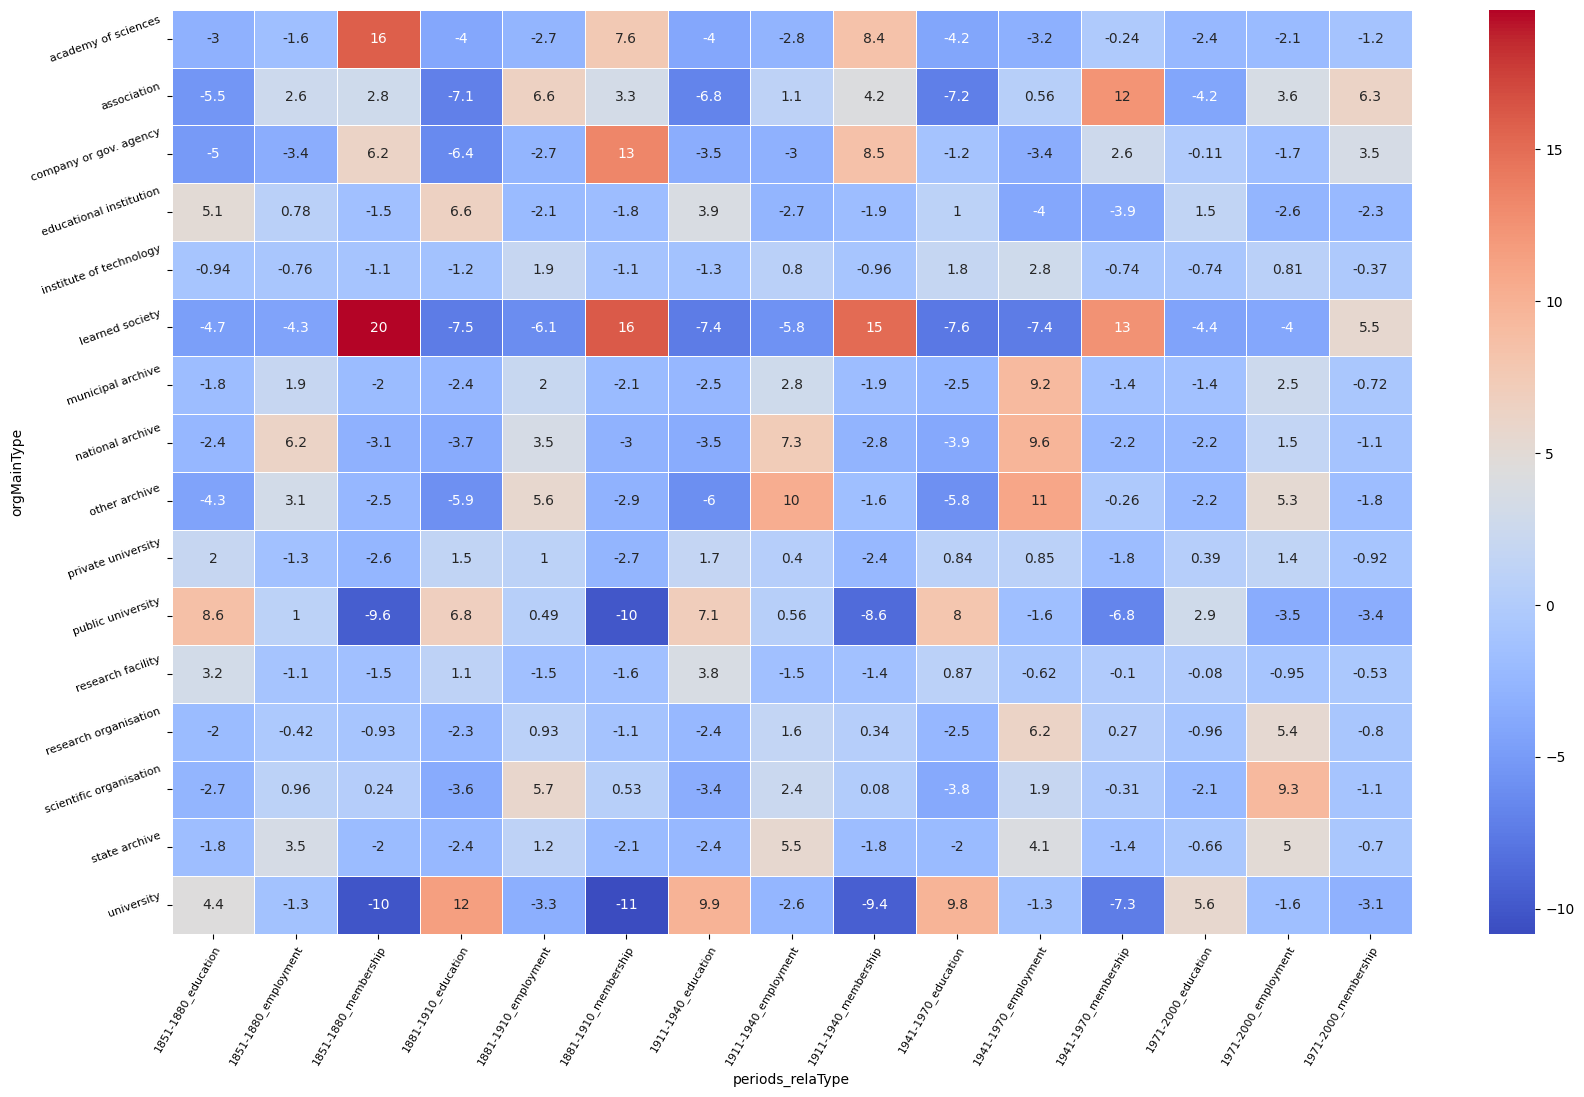

In [254]:
pp = plot_chi2_residuals(ct_wm, figsize=(20, 12))

## Prepare graph


In a heuristic perspective we take the persons as representing relationships among organisations.

Of course these relations are limited in time and with different meaning but in this general inspection of the field, we consider all the relationship. Filters are introduced later on.

We will create a projection of the graph on organisations and keep in a first stage all relationships, with types and periods, one per relationship, where the joining elements are those concerning uniquely the person

In [255]:
### Join on common organisation: Cartesian product -> produces a lot of rows !
merged = pd.merge(df_prep, df_prep, on=['uriPer','labelPer','birthYear', 'periods'])
print(len(merged))


25601


In [256]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriOrg_x'] < (merged['uriOrg_y'])]


In [257]:
### Inspect
print(len(merged))
print(list(merged.columns))
merged.iloc[110:114]

9317
['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType_x', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'periods_relaType_y']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y
277,http://www.wikidata.org/entity/Q103862401,Philipp Messner,1975,http://www.wikidata.org/entity/Q1540070,Schule für Gestaltung Basel,art academy | kunstgewerbeschule,educational institution,education,1971-2000,1971-2000_education,http://www.wikidata.org/entity/Q1720153,Schule für Erwachsenenbildung,kolleg | q20197976 | school,educational institution,education,1971-2000_education
278,http://www.wikidata.org/entity/Q103862401,Philipp Messner,1975,http://www.wikidata.org/entity/Q1540070,Schule für Gestaltung Basel,art academy | kunstgewerbeschule,educational institution,education,1971-2000,1971-2000_education,http://www.wikidata.org/entity/Q1622181,Academy of Art and Design,art academy | university of applied sciences (...,university,employment,1971-2000_employment
288,http://www.wikidata.org/entity/Q103862401,Philipp Messner,1975,http://www.wikidata.org/entity/Q1720153,Schule für Erwachsenenbildung,kolleg | q20197976 | school,educational institution,education,1971-2000,1971-2000_education,http://www.wikidata.org/entity/Q206702,University of Zurich,comprehensive university | university,university,employment,1971-2000_employment
294,http://www.wikidata.org/entity/Q103862401,Philipp Messner,1975,http://www.wikidata.org/entity/Q1622181,Academy of Art and Design,art academy | university of applied sciences (...,university,employment,1971-2000,1971-2000_employment,http://www.wikidata.org/entity/Q206702,University of Zurich,comprehensive university | university,university,employment,1971-2000_employment


In [258]:
### Available ORIGINAL relationships
print(df_p.groupby(by='relaType').size())

relaType
education     2737
employment    2077
membership    1701
dtype: int64


In [259]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
4,employment,employment,1396
8,membership,membership,1337
0,education,education,1102
5,employment,membership,1096
3,employment,education,1078
2,education,membership,1046
1,education,employment,1030
7,membership,employment,631
6,membership,education,601


### Swap values in order to have the same orientation for all relationships

All relationships should have the same 'orientation', which is determined by alphabetical order:

education -> employment -> membership

In [260]:
### Example
df = pd.DataFrame({
    'column1': ['A', 'B', 'C', 'D'],
    'column2': ['X', 'Y', 'Z', 'W']
})

condition = df['column1'] < df['column2']
df.loc[condition, ['column1', 'column2']] = df.loc[condition, ['column2', 'column1']].values

print(df)

  column1 column2
0       X       A
1       Y       B
2       Z       C
3       W       D


In [261]:
### Test whether the relationship types are in the wrong alphabetical order.
condition = merged.relaType_x > merged.relaType_y

In [262]:
### Transpose under condition that the relation orientation is 'wrong',
# i.e. not according the alphabatical order

merged.loc[condition, 
    ['uriOrg_x','labelOrg_x','orgMainType_x','relaType_x', 'uriOrg_y','labelOrg_y','orgMainType_y','relaType_y']] = \
        merged.loc[condition,
    ['uriOrg_y','labelOrg_y','orgMainType_y','relaType_y','uriOrg_x','labelOrg_x','orgMainType_x','relaType_x']].values

In [263]:
### Inspect

merged.iloc[110:117]

,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y
277,http://www.wikidata.org/entity/Q103862401,Philipp Messner,1975,http://www.wikidata.org/entity/Q1540070,Schule für Gestaltung Basel,art academy | kunstgewerbeschule,educational institution,education,1971-2000,1971-2000_education,http://www.wikidata.org/entity/Q1720153,Schule für Erwachsenenbildung,kolleg | q20197976 | school,educational institution,education,1971-2000_education
278,http://www.wikidata.org/entity/Q103862401,Philipp Messner,1975,http://www.wikidata.org/entity/Q1540070,Schule für Gestaltung Basel,art academy | kunstgewerbeschule,educational institution,education,1971-2000,1971-2000_education,http://www.wikidata.org/entity/Q1622181,Academy of Art and Design,art academy | university of applied sciences (...,university,employment,1971-2000_employment
288,http://www.wikidata.org/entity/Q103862401,Philipp Messner,1975,http://www.wikidata.org/entity/Q1720153,Schule für Erwachsenenbildung,kolleg | q20197976 | school,educational institution,education,1971-2000,1971-2000_education,http://www.wikidata.org/entity/Q206702,University of Zurich,comprehensive university | university,university,employment,1971-2000_employment
294,http://www.wikidata.org/entity/Q103862401,Philipp Messner,1975,http://www.wikidata.org/entity/Q1622181,Academy of Art and Design,art academy | university of applied sciences (...,university,employment,1971-2000,1971-2000_employment,http://www.wikidata.org/entity/Q206702,University of Zurich,comprehensive university | university,university,employment,1971-2000_employment
295,http://www.wikidata.org/entity/Q103862401,Philipp Messner,1975,http://www.wikidata.org/entity/Q1720153,Schule für Erwachsenenbildung,art academy | university of applied sciences (...,educational institution,education,1971-2000,1971-2000_employment,http://www.wikidata.org/entity/Q1622181,Academy of Art and Design,kolleg | q20197976 | school,university,employment,1971-2000_education
301,http://www.wikidata.org/entity/Q1038865,Carl Hinrichs,1900,http://www.wikidata.org/entity/Q153006,Freie Universität Berlin,comprehensive university | open-access publish...,university,employment,1881-1910,1881-1910_employment,http://www.wikidata.org/entity/Q882788,Secret State Archives Prussian Cultural Herita...,archive,other archive,employment,1881-1910_employment
304,http://www.wikidata.org/entity/Q1038865,Carl Hinrichs,1900,http://www.wikidata.org/entity/Q153006,Freie Universität Berlin,comprehensive university | open-access publish...,university,employment,1881-1910,1881-1910_employment,http://www.wikidata.org/entity/Q32120,Martin Luther University Halle-Wittenberg,comprehensive university | public university,public university,employment,1881-1910_employment


In [264]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
1,education,employment,2108
4,employment,membership,1727
2,education,membership,1647
3,employment,employment,1396
5,membership,membership,1337
0,education,education,1102


In [265]:
### Concat relationships
merged['relaType_concat'] = merged.apply(lambda x: x.relaType_x + '_' +x.relaType_y, axis=1)

In [266]:
print(list(merged.columns))
merged.iloc[110:112]


['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType_x', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'periods_relaType_y', 'relaType_concat']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y,relaType_concat
277,http://www.wikidata.org/entity/Q103862401,Philipp Messner,1975,http://www.wikidata.org/entity/Q1540070,Schule für Gestaltung Basel,art academy | kunstgewerbeschule,educational institution,education,1971-2000,1971-2000_education,http://www.wikidata.org/entity/Q1720153,Schule für Erwachsenenbildung,kolleg | q20197976 | school,educational institution,education,1971-2000_education,education_education
278,http://www.wikidata.org/entity/Q103862401,Philipp Messner,1975,http://www.wikidata.org/entity/Q1540070,Schule für Gestaltung Basel,art academy | kunstgewerbeschule,educational institution,education,1971-2000,1971-2000_education,http://www.wikidata.org/entity/Q1622181,Academy of Art and Design,art academy | university of applied sciences (...,university,employment,1971-2000_employment,education_employment


In [267]:
df_graph=merged.groupby(['periods', 'relaType_concat', 'uriOrg_x', 'labelOrg_x', 'orgMainType_x',  
                         'uriOrg_y', 'labelOrg_y', 'orgMainType_y'],
               as_index=False)\
    .agg({'labelPer': '|'.join, 'uriPer': '|'.join})

df_graph['number'] = df_graph.labelPer.apply(lambda x : len(x.split('|')))


In [268]:
print(len(df_graph))
df_graph.sort_values('number',ascending=False).head()


8344


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
436,1851-1880,education_membership,http://www.wikidata.org/entity/Q273570,École des chartes,public university,http://www.wikidata.org/entity/Q3487972,Société de l’histoire de France,learned society,Frantz Funck-Brentano|Jules Viard|Philippe Lau...,http://www.wikidata.org/entity/Q1445752|http:/...,18
418,1851-1880,education_membership,http://www.wikidata.org/entity/Q273570,École des chartes,public university,http://www.wikidata.org/entity/Q28845821,Société de l'histoire de Paris et de l'Île-de-...,learned society,Jules Viard|Philippe Lauer|René Poupardin|Mari...,http://www.wikidata.org/entity/Q16862516|http:...,16
1537,1881-1910,education_education,http://www.wikidata.org/entity/Q102400615,Examination Board for Teachers at Secondary Sc...,educational institution,http://www.wikidata.org/entity/Q3563550,"Faculty of Arts, Charles University in Prague",university,Josef Dostál|Josef Hráský|Antonín Haas|Františ...,http://www.wikidata.org/entity/Q12025959|http:...,16
2282,1881-1910,education_membership,http://www.wikidata.org/entity/Q24685998,Instituto Cardenal Cisneros,educational institution,http://www.wikidata.org/entity/Q35854422,"Cuerpo Facultativo de Archiveros, Bibliotecari...",company or gov. agency,María Almudévar y Lorenzo|Consuelo del Castill...,http://www.wikidata.org/entity/Q104546887|http...,14
422,1851-1880,education_membership,http://www.wikidata.org/entity/Q273570,École des chartes,public university,http://www.wikidata.org/entity/Q2985434,Comité des Travaux Historiques et Scientifiques,learned society,Louis Demaison|Jules Viard|René Poupardin|Char...,http://www.wikidata.org/entity/Q16855647|http:...,14


### Explore contingency table of relationship pairs to periods

In [269]:


### Contingency table
X = 'periods'
Y = 'relaType_concat'  

ddf = df_graph[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
relaType_concat,,,,,,
education_education,103,194,258,267,132,954
education_employment,187,406,443,596,308,1940
education_membership,274,351,349,253,130,1357
employment_employment,159,331,257,422,182,1351
employment_membership,403,407,404,263,95,1572
membership_membership,403,263,272,166,66,1170
Total,1529,1952,1983,1967,913,8344


In [271]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [272]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 693.43 , dof : 20
p-value : 5.442805629269088e-134
phi2 = inertie (variance totale) : 0.08310474074309691
Cramer:  0.14413946435925945


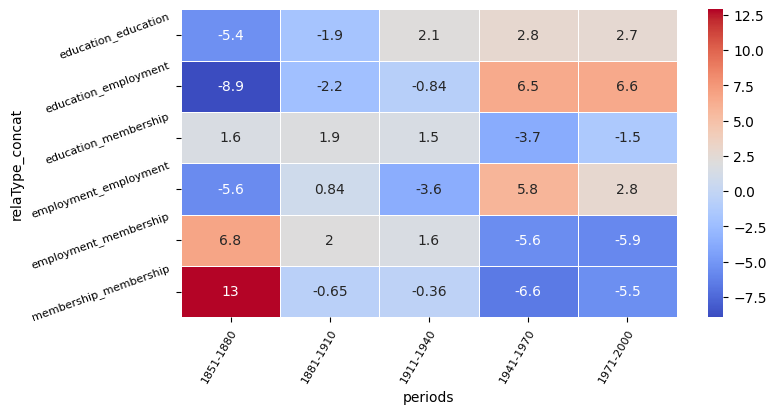

In [273]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Graph analysis


We will explore some aspects of the relationships:

* which organisations are connected through education, but this only at the level of universities, not earlier education stages
* in the same perspective (same kind of relations), we will explore memberships and employments, keeping them separated
* we will then ask what appears regarding the relationship between employment and membership
* we finally inspect if some kind of educational institutions (at unversity level) lead to specific employments or memberships.






### Organisations connected through higher education

In [274]:
pprint.pprint(sorted(df_mainTypes.mainType.to_list()))

['academy of sciences',
 'association',
 'company or gov. agency',
 'educational institution',
 'institute of technology',
 'learned society',
 'municipal archive',
 'national archive',
 'other archive',
 'private university',
 'public university',
 'research facility',
 'research organisation',
 'scientific organisation',
 'state archive',
 'university']


In [275]:
types_list=['university', 'public university', 'private university']

In [276]:
df_edu_graph = df_graph[(df_graph.relaType_concat == 'education_education') \
                     & (df_graph.orgMainType_x.isin(types_list)) \
                     & (df_graph.orgMainType_y.isin(types_list))  ]

print(len(df_edu_graph))
df_edu_graph.iloc[:2]

383


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
3,1851-1880,education_education,http://www.wikidata.org/entity/Q1115639,Franz Joseph University,university,http://www.wikidata.org/entity/Q154804,Leipzig University,public university,Albert Berger,http://www.wikidata.org/entity/Q66119637,1
4,1851-1880,education_education,http://www.wikidata.org/entity/Q1115639,Franz Joseph University,university,http://www.wikidata.org/entity/Q20266330,Frederick William University Berlin,university,Albert Berger,http://www.wikidata.org/entity/Q66119637,1


In [277]:
df_edu_graph.sort_values(by='number',ascending=False).iloc[:2]

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
1553,1881-1910,education_education,http://www.wikidata.org/entity/Q12047389,"Faculty of Law, Charles University in Prague",university,http://www.wikidata.org/entity/Q3563550,"Faculty of Arts, Charles University in Prague",university,Emil Axman|Vladimír Klecanda|František Čáda|Ja...,http://www.wikidata.org/entity/Q11878541|http:...,10
79,1851-1880,education_education,http://www.wikidata.org/entity/Q273570,École des chartes,public university,http://www.wikidata.org/entity/Q273631,École pratique des hautes études,public university,Louis Demaison|Philippe Lauer|Georges de Mante...,http://www.wikidata.org/entity/Q16855647|http:...,6


In [278]:
### Number of relationships by period
print(df_edu_graph.groupby('periods').size())

periods
1851-1880    50
1881-1910    96
1911-1940    82
1941-1970    97
1971-2000    58
dtype: int64


### Inspect a specific period

In [279]:
p = '1881-1910' #'1851-1880' #'1911-1940'

In [280]:
df_edu_graph_p = df_edu_graph[(df_edu_graph.periods==p)]
df_edu_graph_p.sort_values(by='number',ascending=False).head(2)

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
1553,1881-1910,education_education,http://www.wikidata.org/entity/Q12047389,"Faculty of Law, Charles University in Prague",university,http://www.wikidata.org/entity/Q3563550,"Faculty of Arts, Charles University in Prague",university,Emil Axman|Vladimír Klecanda|František Čáda|Ja...,http://www.wikidata.org/entity/Q11878541|http:...,10
1682,1881-1910,education_education,http://www.wikidata.org/entity/Q273570,École des chartes,public university,http://www.wikidata.org/entity/Q273631,École pratique des hautes études,public university,André Berthier|André Vernet|Jean-François Lema...,http://www.wikidata.org/entity/Q2847277|http:/...,5


In [281]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriOrg_x'], e['uriOrg_y'],
     {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
      ## the weight ist the number of persons in this relationship
      'weight':e['number']}
     )) 
     for e in df_edu_graph_p.to_dict(orient='records')]
print(len(l))

96


In [282]:
edu_graph_p=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
edu_graph_p.add_edges_from(l)

naf.basic_graph_properties(edu_graph_p)

### Create a list of graphs, one per component
edu_graph_p_S = [edu_graph_p.subgraph(c).copy() for c in nx.connected_components(edu_graph_p)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(edu_graph_p_S)], key = lambda row: row[1], reverse=True)
print(ln[:5])

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 95,
 'number_of_edges': 96,
 '------': '------',
 'is connected': False,
 'components': 25,
 'density': 0.021500559910414333}
[[4, 23], [0, 16], [12, 6], [1, 3], [2, 3]]


In [283]:
### test if second component is significantly smaller 
# than first
if ln[1][1]*20 < ln[0][1]:
    print('Just one big component')
else :
    print('Beware: more than one big component !')    

Beware: more than one big component !


In [284]:
### Alternative way with just one graph
pG = edu_graph_p_S[0]
naf.basic_graph_properties(pG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 16,
 'number_of_edges': 19,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.15833333333333333}


In [285]:
df_orgPeriod.sort_values(by='period_members_number', ascending=False).head(2)

,uriOrg,labelOrg,orgMainType,periods,period_members_number
2083,http://www.wikidata.org/entity/Q35854422,"Cuerpo Facultativo de Archiveros, Bibliotecari...",company or gov. agency,1881-1910,117
1520,http://www.wikidata.org/entity/Q273570,École des chartes,public university,1911-1940,90


In [286]:
df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']
df_opl.head()


,uri,label,mainType,membersNumber
8,http://www.wikidata.org/entity/Q10185,Berliner Zeitung,association,1
12,http://www.wikidata.org/entity/Q102398072,philosophy faculty of the German university of...,university,5
14,http://www.wikidata.org/entity/Q102398119,Deutsche wissenschaftliche Prüfungs-kommission...,educational institution,2
16,http://www.wikidata.org/entity/Q102398197,"Faculty of Law, German University in Prague",university,4
17,http://www.wikidata.org/entity/Q102398283,"faculty of science, German University in Prague",university,1


In [287]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'mainType':e['mainType'],
                        'membersNumber':e['membersNumber']}
     ) for e in df_opl.to_dict(orient='records')])
## Add attributes
nx.set_node_attributes(pG, ln)
pprint.pprint(list(pG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q102398197',
  {'label': 'Faculty of Law, German University in Prague',
   'mainType': 'university',
   'membersNumber': 4}),
 ('http://www.wikidata.org/entity/Q154804',
  {'label': 'Leipzig University',
   'mainType': 'public university',
   'membersNumber': 8})]


In [288]:
mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
print(mn_s.groupby(by=mn_s).size().sort_values(ascending=False))

public university    10
university            6
dtype: int64


####  Create dataframe and inspect node properties

In [289]:
### Eigenvector
le = list(nx.eigenvector_centrality(pG, 
                        max_iter=200, weight='weight').items())
nx.set_node_attributes(pG, dict(le), 'eigenvector')
pprint.pprint(list(pG.nodes.data())[:1])

[('http://www.wikidata.org/entity/Q102398197',
  {'eigenvector': 0.02308322417735315,
   'label': 'Faculty of Law, German University in Prague',
   'mainType': 'university',
   'membersNumber': 4})]


In [290]:
### Betweenness
lb = list(nx.betweenness_centrality(pG, weight='weight').items())
nx.set_node_attributes(pG, dict(lb), 'betweenness')
pprint.pprint(list(pG.nodes.data())[:1])


[('http://www.wikidata.org/entity/Q102398197',
  {'betweenness': 0.0,
   'eigenvector': 0.02308322417735315,
   'label': 'Faculty of Law, German University in Prague',
   'mainType': 'university',
   'membersNumber': 4})]


In [291]:
### Export node attributes to dataframe
nodes_data ={node: pG.nodes[node] for node in pG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True, names='id')
nodes_df.head(2)


,id,label,mainType,membersNumber,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q102398197,"Faculty of Law, German University in Prague",university,4,0.023083,0.0
1,http://www.wikidata.org/entity/Q154804,Leipzig University,public university,8,0.585158,0.495238


In [292]:
df_mainTypes

,mainType,number
15,university,1448
10,public university,1252
2,company or gov. agency,1015
1,association,634
3,educational institution,557
5,learned society,533
8,other archive,353
0,academy of sciences,152
7,national archive,131
13,scientific organisation,127


In [293]:
### exclude less relevant or dirty classifications
lt=[t for t in df_mainTypes.mainType.to_list()
                if ('educat' not in t)  & ('classif' not in t)]
pprint.pprint(lt)

['university',
 'public university',
 'company or gov. agency',
 'association',
 'learned society',
 'other archive',
 'academy of sciences',
 'national archive',
 'scientific organisation',
 'private university',
 'research organisation',
 'municipal archive',
 'state archive',
 'research facility',
 'institute of technology']


In [294]:
### source
# https://phrogz.net/css/distinct-colors.html
col_l = [c.strip() for c in '#ff0066, #0000ff, #00aaff,#beb6f2, #b6e6f2, #e6f2b6, #f2b6b6,#2d50b3, #ccff00, #8c005e, #8c8300'.split(',')]
print(col_l)

['#ff0066', '#0000ff', '#00aaff', '#beb6f2', '#b6e6f2', '#e6f2b6', '#f2b6b6', '#2d50b3', '#ccff00', '#8c005e', '#8c8300']


In [295]:
col_list= [e for e in zip(lt, col_l)]
print(col_list)

[('university', '#ff0066'), ('public university', '#0000ff'), ('company or gov. agency', '#00aaff'), ('association', '#beb6f2'), ('learned society', '#b6e6f2'), ('other archive', '#e6f2b6'), ('academy of sciences', '#f2b6b6'), ('national archive', '#2d50b3'), ('scientific organisation', '#ccff00'), ('private university', '#8c005e'), ('research organisation', '#8c8300')]


In [296]:
color_map=dict([(c[0], (c[1])) for c in col_list])
pprint.pprint(color_map)

{'academy of sciences': '#f2b6b6',
 'association': '#beb6f2',
 'company or gov. agency': '#00aaff',
 'learned society': '#b6e6f2',
 'national archive': '#2d50b3',
 'other archive': '#e6f2b6',
 'private university': '#8c005e',
 'public university': '#0000ff',
 'research organisation': '#8c8300',
 'scientific organisation': '#ccff00',
 'university': '#ff0066'}


In [ ]:
### Manually modified list
color_map = {'academy of sciences': '#f2b6b6',
 'association': '#beb6f2',
 'company or gov. agency': '#00aaff',
 'learned society': '#b6e6f2',
 'national archive': '#2d50b3',
 'other archive': '#e6f2b6',
 'private university': '#8c005e',
 'public university': '#0000ff',
 'research organisation': '#8c8300',
 'scientific organisation': '#ccff00',
 'university': '#ff0066'}

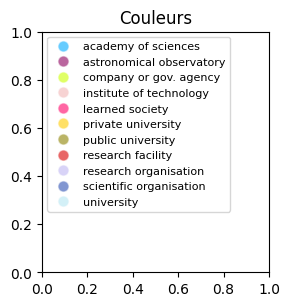

In [313]:

fig = plt.figure(figsize=(3,3))


### Create lists of colors and labels
colors = [color_map.keys()]
 

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=0.6
                            ) for label, color in color_map.items() ],
                            loc='upper left', fontsize=8)
plt.tight_layout() # rect=[0,0,0.8,1]

plt.title('Couleurs')

plt.show()

In [299]:
### Create a function that plots the comparison between values and properties

def compare_with_scatter_plot(dataframe, value_1, value_2, point_column,point_ratio=1, 
                              c_category='', color_map='', figsize=(12,12), 
                              legend_loc='upper right',title='', 
                              n_label ='', label_cut_value=''):

    ### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    # Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
    # Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    # Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point



    df=dataframe
    # df_extr=nodes_df[nodes_df.betweenness > 0].sort_values(by='betweenness', ascending=False)

    alpha=0.7

    ### Manage point colors:
    # https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

    plt.figure(figsize=figsize)


    ### Create lists of colors and labels
    colors = [color_map[category] for category in df[c_category]]
 



    ax = plt.scatter(df[value_1],
                df[value_2],
            marker='o',
            s = [v*point_ratio for i,v in df[point_column].items()],
            color=colors,        
            alpha=alpha)
    plt.xlabel(value_1.capitalize())
    plt.ylabel(value_2.capitalize())






    ### Labels
    test_v1 = df[value_1].quantile([0.97]).item()
    test_v2 = df[value_2].quantile([0.95]).item()
    print(test_v1,test_v2)


    if len(n_label)>0:
        for i,row in list(df.loc[(df[value_1]>test_v1)|(df[value_2]>test_v2)]\
                          [[n_label,value_1,value_2]].iterrows()):
            plt.annotate(row[n_label][:30],(row[value_1], row[value_2]), fontsize=6)

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=alpha
                            ) for label, color in color_map.items() 
                                    if label in types_list ],
                            loc=legend_loc, fontsize=8)
    plt.tight_layout() # rect=[0,0,0.8,1]

    plt.title(title)

    # plt.savefig('plots/revenus_eigenvector_20210526.jpg')
    plt.show()

0.5464094573167004 0.48809523809523814


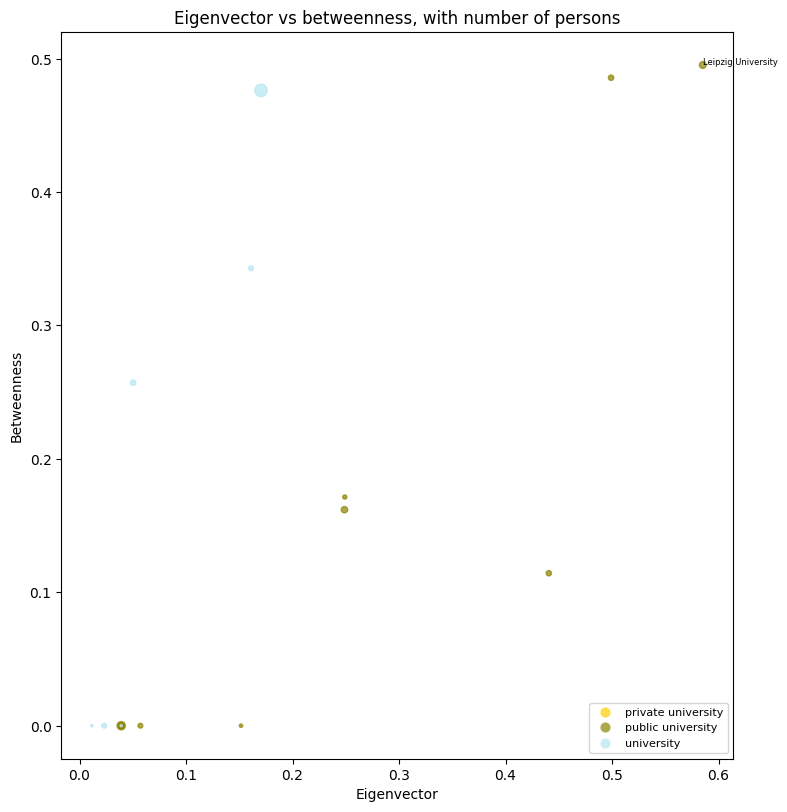

Spearman's rank correlation: 0.8007371641245442


In [300]:
compare_with_scatter_plot(nodes_df, 'eigenvector', 'betweenness', 'membersNumber', 
                          point_ratio=3, c_category='mainType',
                          color_map=color_map, figsize=(8,8), 
                          legend_loc='lower right', 
                          title='Eigenvector vs betweenness, with number of persons', 
                          n_label='label', label_cut_value='membersNumber' )

corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
print("Spearman's rank correlation: {}".format(corr_spear.iloc[0,1]))

In [301]:
list(nodes_df.columns)

['id', 'label', 'mainType', 'membersNumber', 'eigenvector', 'betweenness']

In [302]:
print('Betweenness')
pprint.pprint((nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))
print('\n-----\nEigenvector')
pprint.pprint((nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))

Betweenness
                                                label           mainType  \
1                                  Leipzig University  public university   
13                            University of Göttingen  public university   
4                                University of Vienna         university   
14                                University of Basel         university   
7   philosophy faculty of the German university of...         university   
5                            University of Greifswald  public university   
10             Ludwig-Maximilians-Universität München  public university   

   membersNumber  
1              8  
13             5  
4             27  
14             4  
7              5  
5              3  
10             7  

-----
Eigenvector
                                     label           mainType membersNumber
1                       Leipzig University  public university             8
13                 University of Göttingen  public unive

#### Plot graph

In [303]:
pict_addr = 'images/organisations/edu_edu_' + p +'.svg'
print(pict_addr)

images/organisations/edu_edu_1881-1910.svg


In [304]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]
node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                        label=label, markerfacecolor=color, 
                        markersize=12, alpha=alpha_n
                        )
                        for label, color in color_map.items()
                        if label in types_list ],
                        loc='lower right', fontsize=12)


### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr
plt.savefig(pict_addr)
#plt.show()
plt.close()


### Communitites

In [305]:
l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
print( len(l_communities))
sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
print([c[1] for c in sl_communities])
print(sl_communities[-1:])


3
[8, 5, 3]
[({'http://www.wikidata.org/entity/Q102398197', 'http://www.wikidata.org/entity/Q102398072', 'http://www.wikidata.org/entity/Q102398283'}, 3)]


In [306]:
for i in range(0,3):
   print('\n\nCommunity '+ str(i), '\nBetweenness')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))
   print('\n-----\nEigenvector')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))




Community 0 
Betweenness
                       label           mainType membersNumber
1         Leipzig University  public university             8
13   University of Göttingen  public university             5
14       University of Basel         university             4
5   University of Greifswald  public university             3

-----
Eigenvector
                       label           mainType membersNumber
1         Leipzig University  public university             8
13   University of Göttingen  public university             5
2      Heidelberg University  public university             5
5   University of Greifswald  public university             3


Community 1 
Betweenness
                      label           mainType membersNumber
4      University of Vienna         university            27
6   University of Innsbruck  public university             6
8     University of Marburg  public university             5
11          Lviv University  public university            12

-

#### Plot communitites graph

In [307]:
pict_addr_comm = 'images/organisations/edu_edu_communities_' + p +'.svg'
print(pict_addr_comm)

images/organisations/edu_edu_communities_1881-1910.svg


In [308]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]

node_colors = []
for n in g.nodes.data():
    if n[0] in list(sl_communities[0][0]):
        node_colors.append('red')
    elif n[0] in list(sl_communities[1][0]):
        node_colors.append('blue')
    elif n[0] in list(sl_communities[2][0]):
        node_colors.append('green')
    elif n[0] in list(sl_communities[3][0]):
        node_colors.append('orange')
    elif n[0] in list(sl_communities[4][0]):
        node_colors.append('maroon')
    else:
        node_colors.append('lightGrey')        


edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5



### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr_comm
plt.savefig(pict_addr)
#plt.show()
plt.close()


## Create general function

In [309]:
def generate_report_and_plots(df, concatRelaType, type_list, doc_addr, df_orgPeriod):

    with open(doc_addr, "w") as myfile:
        myfile.write('# Report for relations: ' + concatRelaType + '\n')


    df_g = df[(df.relaType_concat == concatRelaType) \
                     & (df.orgMainType_x.isin(type_list)) \
                     & (df.orgMainType_y.isin(type_list))  ]

    txt = str(df_g.groupby('periods').size())

    with open(doc_addr, "a") as myfile:
        myfile.write('\n'+txt + '\n')

    for p in df_g['periods'].unique():
        print(str(p))   

        with open(doc_addr, "a") as myfile:
            myfile.write('\n\n\n## Values for ' + p + '\n')

        df_g_p = df_g[df_g.periods==p]
        
        with open(doc_addr, "a") as myfile:
            myfile.write('\nNumber of relationships for this period ' + str(len(df_g_p)) + '\n')
        
        l = [tuple(
            (e['uriOrg_x'], e['uriOrg_y'],
            {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
            ## the weight ist the number of persons in this relationship
            'weight':e['number']}
            )) 
            for e in df_g_p.to_dict(orient='records')]
        
        graph_p=nx.Graph()
        graph_p.add_edges_from(l)

        txt = 'Number of nodes: ' + str(graph_p.number_of_nodes())+\
                '\nNumber of edges: ' + str(graph_p.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### Components
        graph_p_S = [graph_p.subgraph(c).copy() 
                     for c in nx.connected_components(graph_p)]

        ln = sorted([[i,len(s.nodes)] for i,s in enumerate(graph_p_S)], key = lambda row: row[1], reverse=True)
        try:
            if ln[1][1]*20 < ln[0][1]:
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nJust one big component with ' + str(graph_p_S[0].number_of_nodes()) + ' nodes\n')            
            else :
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nBeware: more than one big component !'  + '\n')
        except Exception as e:
             print(e)            
            
        ### Alternative way with just one graph
        pG = graph_p_S[0]

        txt = 'Number of nodes for first component: ' + str(pG.number_of_nodes())+\
                '\nNumber of edges for first component: ' + str(pG.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### No treatment for smaller graphs
        if int(pG.number_of_nodes()) > 30:

            ### Prepare data to add to nodes

            df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
            df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']

            ln = dict([(e['uri'],
                {'label':e['label'], 'mainType':e['mainType'],
                                    'membersNumber':e['membersNumber']}
                ) for e in df_opl.to_dict(orient='records')])
            ## Add attributes
            nx.set_node_attributes(pG, ln)

            mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
            txt= str(list(mn_s.groupby(by=mn_s).size().sort_values(ascending=False).items()))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            ### Eigenvector
            try:
                le = list(nx.eigenvector_centrality(pG, 
                                        max_iter=1000, weight='weight').items())
            except Exception as e:
                print(e)    
            nx.set_node_attributes(pG, dict(le), 'eigenvector')   

            ### Betweenness
            lb = list(nx.betweenness_centrality(pG, weight='weight').items())
            nx.set_node_attributes(pG, dict(lb), 'betweenness')


            ### Export node attributes to dataframe
            nodes_data ={node: pG.nodes[node] for node in pG.nodes}
            nodes_df = pd.DataFrame(nodes_data).T
            nodes_df.reset_index(inplace=True, names='id')

            corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
            txt = "Spearman's rank correlation of eidenvector and betweenness: {}".format(corr_spear.iloc[0,1])
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            txt = 'Eigenvector\n' + \
                str(nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7) )+\
                '\n-----\nBetweenness'+\
                str(nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')


            pict_addr = 'images/organisations/' + concatRelaType + '_' + p +'.svg'        


            ### Plot the graph
            g = pG
            # n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
            n_size = np.log(nx.number_of_nodes(g))*10

            graph_layout = 'spring_layout'
            n_k = np.log(nx.number_of_nodes(g))/20 #2.5

            ### Define the layout, i.e. the choice 
            # of the algorithm for the representation of the graph.

            if graph_layout == 'fruchterman_reingold':
                pos = nx.fruchterman_reingold_layout(g)
            elif graph_layout == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(g)
            elif graph_layout == 'spring_layout':
                pos = nx.spring_layout(g, k = n_k)  
            else:
                pos = nx.kamada_kawai_layout(g)

            # https://networkx.org/documentation/stable/reference/drawing.html
            plt.figure(figsize = (n_size,n_size))

            node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
            #node_size = [d[1]*100 for d in nx.degree(g)]
            #node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

            edge_size = [e[2]['weight'] for e in g.edges.data()]
            edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

            node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


            nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color='blue', alpha=0.6)
            nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
            nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
            #nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

            alpha_n=0.5

            plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                                    label=label, markerfacecolor=color, 
                                    markersize=8, alpha=alpha_n
                                    )
                                    for label, color in color_map.items()],
                                    loc='lower right', fontsize=8)


            ### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
            plt.tight_layout(pad=60)
            pict_addr = pict_addr
            plt.savefig(pict_addr)
            #plt.show()
            plt.close()


            ### Identify communitites
            l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
            sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
            txt= 'Number of communitites: ' + str(len(l_communities)) +\
                    '\nNumber of nodes per community: ' + str([c[1] for c in sl_communities])
            with open(doc_addr, "a") as myfile:
                myfile.write('\n'+ txt  + '\n')

            communities_print = 'Communities: \n'
            try:
                for i in range(0,5):
                    communities_print += '\n\nCommunity '+ str(i) + '\nBetweenness'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ]\
                                                .sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                    communities_print += '\n-----\nEigenvector'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ communities_print  + '\n')
            except Exception as e:
                 print(e)        

        else:
            print('Too small graph to be analyzed!')        


In [310]:
print(df_mainTypes.mainType.to_list())

['university', 'public university', 'company or gov. agency', 'association', 'educational institution', 'learned society', 'other archive', 'academy of sciences', 'national archive', 'scientific organisation', 'private university', 'research organisation', 'municipal archive', 'state archive', 'research facility', 'institute of technology']


In [311]:
relationship_type = 'education_education'
generate_report_and_plots(df_graph, relationship_type,
                           ['university','public university','private university'],
                           'analysis_doc/'+relationship_type+'.md',
                           df_orgPeriod)

FileNotFoundError: [Errno 2] No such file or directory: 'analysis_doc/education_education.md'

In [ ]:
relationship_type = 'membership_membership'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

FileNotFoundError: [Errno 2] No such file or directory: 'analysis_doc/membership_membership.md'

In [ ]:
relationship_type = 'employment_employment'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

FileNotFoundError: [Errno 2] No such file or directory: 'analysis_doc/employment_employment.md'